### Начальные условия:

In [1]:
T_sr = 40           ### Температура среды вокруг транзистора

### Параметры транзистора:

In [2]:
P = 15            ### Мощность транзистора
N = 6             ### Количество транзисторов
R = 0.8           ### Тепловое сопротивление между кристаллом и корпусом транзистора
S = 8.66e-5       ### Площадь корпуса транзистора (одинакова для всех слоев до корпуса)
T0 = 150          ### Максимальная температура кристалла транзистора

### Параметры корпуса:

In [3]:
L = 0.2           ### Длина ребра (ширина корпуса)
Z = 0.1           ### Длина корпуса приходящаяся на транзистор
delta_k = 0.01    ### Толщина основания корпуса
lamda_k = 210     ### Теплопроводность материала корпуса

### Параметры материалов слоев между транзистором и корпусом

#### Термопаста:

In [4]:
lamda_p = 8.5     ### Теплопроводность термопасты
delta_p = 6e-5    ### Толщина слоя термопасты

#### Припой (находится между термопастой и медной пластиной, а также между пластиной и корпусом радиатора):

In [5]:
lamda_pr = 50.2   ### Теплопроводность припоя
delta_pr = 1e-5   ### Толщина слоя припоя

#### Медная пластина:

In [6]:
lamda_pl = 400    ### Теплопроводность меди
delta_pl = 5e-4   ### Толщина пластины

### Создадим класс для хранения параметров различных слоев

In [7]:
class material_prop:
    
    def __init__(self, name, lamda, delta):
        
        self.info = {
                    'name': name,     ### Название материала
                    'lamda': lamda,   ### Теплопроводность материала
                    'delta': delta,   ### Толщина слоя материала
                }
        
    def name(self):
        return self.info['name']

    def lamda(self):
        return self.info['lamda']

    def delta(self):
        return self.info['delta']

#### Инициализируем хранилище параметров слоев а так же их количество:

In [8]:
materials = {}
materials_numb = 4

In [9]:
for i in range(materials_numb):
    print(f'Заполните параметры слоя {i}')
    name = input('Введите название слоя - ')
    lamda = float(input('Введите коэффициент теплопроводности слоя [Вт/(м °К)] - '))
    delta = float(input('Введите толщину слоя [м] - '))
    materials[i] = material_prop(name, lamda, delta)

Заполните параметры слоя 0
Введите название слоя - термопаста
Введите коэффициент теплопроводности слоя [Вт/(м °К)] - 8.5
Введите толщину слоя [м] - 6e-5
Заполните параметры слоя 1
Введите название слоя - припой1
Введите коэффициент теплопроводности слоя [Вт/(м °К)] - 50.2
Введите толщину слоя [м] - 1e-5
Заполните параметры слоя 2
Введите название слоя - медная пластина
Введите коэффициент теплопроводности слоя [Вт/(м °К)] - 400
Введите толщину слоя [м] - 5e-4
Заполните параметры слоя 3
Введите название слоя - припой 2
Введите коэффициент теплопроводности слоя [Вт/(м °К)] - 50.2
Введите толщину слоя [м] - 1e-5


### Изобразим наглядно слои между корпусом транзистора и корпусом радиатора

In [10]:
from math import log
import numpy as np

In [11]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

Для уменьшения масштабной разницы слоев, возьмем натуральный логарифм от толщины каждого слоя умноженного на 1е6

(-0.9210340371976184, 25.04549725580619)

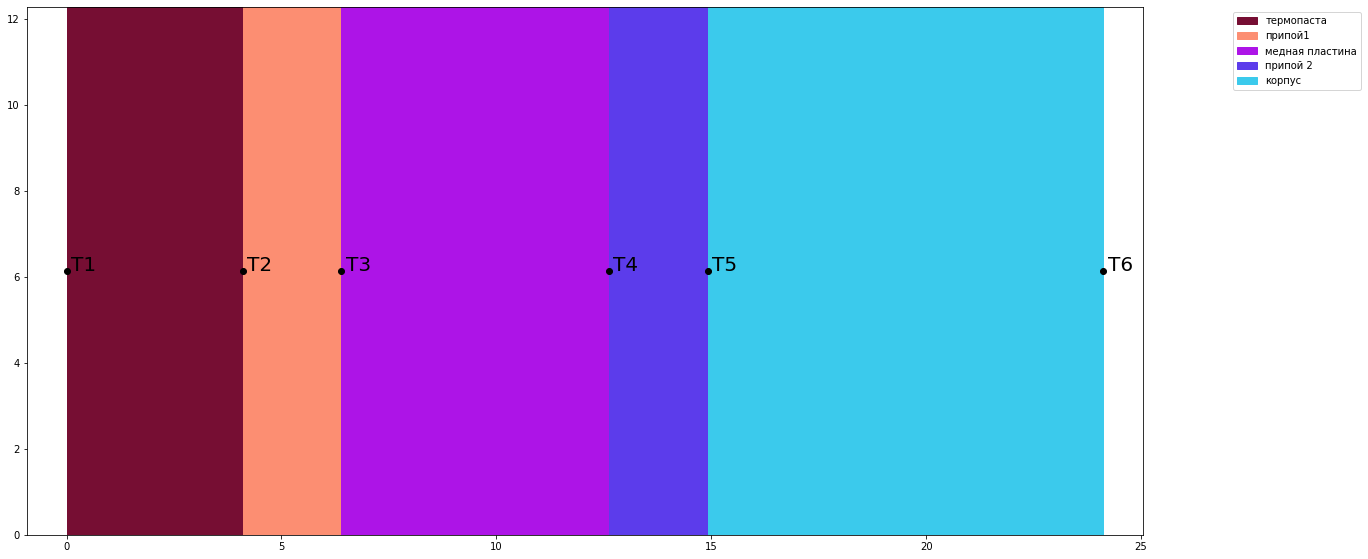

In [12]:
start = (0, 0)
start_x = 0
height = 3 * log(1e6 * (materials[0].delta()))
X = [0]

fig1 = plt.figure(figsize=(20, 10))
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(len(materials)):
    width = log(1e6 * materials[i].delta())
    ax1.add_patch(
        patches.Rectangle(start, width, height,
                         label=f'{materials[i].name()}',
                          color=np.random.rand(3)))
    
    start_x += width
    X.append(start_x)
    start = (start_x, 0)

width = log(1e6 * delta_k)
ax1.add_patch(
    patches.Rectangle(start, width, height,
                     label='корпус',
                      color=np.random.rand(3)))
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

X.append(start_x + width)
limx = (0 - width * 0.1, start_x + width * 1.1)
limy = (0, height)

Y = [height / 2] * len(X)
for i in range(len(X)):
    plt.plot(X[i], Y[i], marker='o', color='black');
    plt.annotate(f'T{i+1}', xy=(X[i] + 0.1,Y[i]), size=20)

plt.ylim(limy)
plt.xlim(limx)

Где T1, .., T6 - соответствующие температуры (Т1 - температура на стыке термопасты и корпуса транзистора)

### Определим температуры в точках соприкосновения слоев

Инициализируем хранилище температур:

In [15]:
T = []

Для определения температуры T1 воспользуемся расчетом изменения температуры через тепловое сопротивление внутри транзистора

In [16]:
T1 = T0 - P * R
T.append(T1)

Рассчитаем плотность теплового потока:

In [17]:
q = P / S
print(q)

173210.16166281755


Температуры Т2 - Т5 рассчитаем пользуясь свойством равенства плотностей теплового потока при одинаковой площади сечения слоев: 

In [18]:
def temperature(t, lamda, delta, q):
    return t - delta * q / lamda

In [19]:
for i in range(len(materials)):
    t = temperature(T[i],
                   materials[i].lamda(),
                   materials[i].delta(),
                   q)
    T.append(t)

С учетом изменения площади слоя, для корпуса произведем расчет воспользовавшись формулой полного теплового потока:

In [20]:
T.append(T[-1] - P / ((L * Z) * (1 / (delta_k / lamda_k))))

Посмотрим на динамику изменения температуры по толщине:

(-0.9210340371976184, 25.04549725580619)

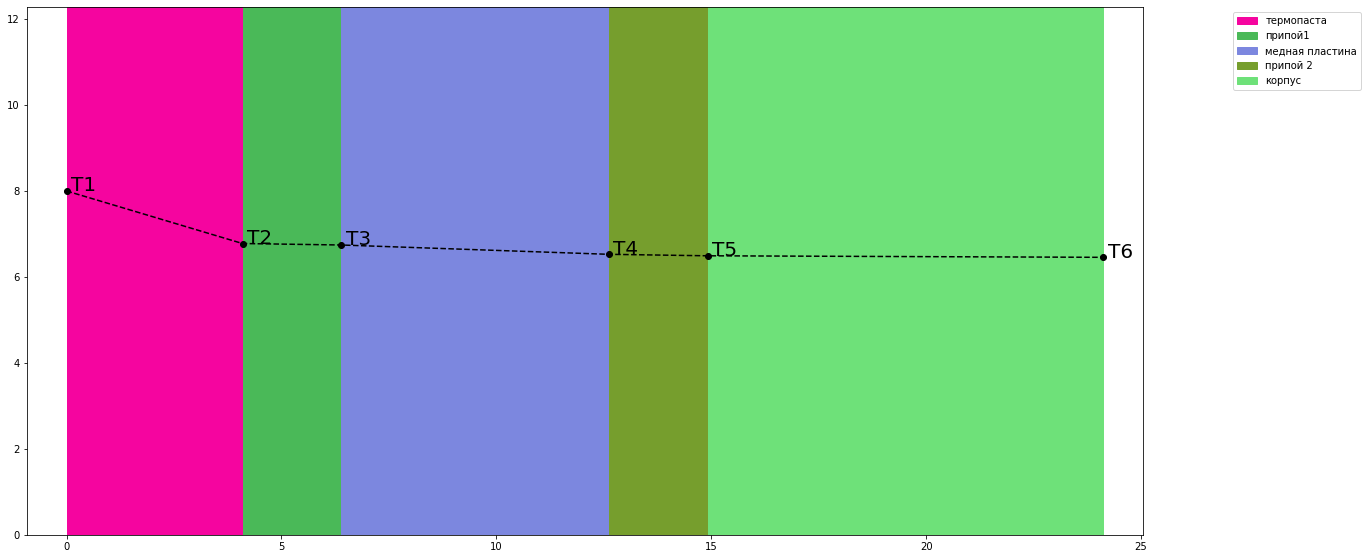

In [21]:
start = (0, 0)
start_x = 0
height = 3 * log(1e6 * (materials[0].delta()))
X = [0]

fig1 = plt.figure(figsize=(20, 10))
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(len(materials)):
    width = log(1e6 * materials[i].delta())
    ax1.add_patch(
        patches.Rectangle(start, width, height,
                         label=f'{materials[i].name()}',
                          color=np.random.rand(3)))
    
    start_x += width
    X.append(start_x)
    start = (start_x, 0)

width = log(1e6 * delta_k)
ax1.add_patch(
    patches.Rectangle(start, width, height,
                     label='корпус',
                      color=np.random.rand(3)))
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))

X.append(start_x + width)
T_x = list(map(lambda x: x - 130, T))
limx = (0 - width * 0.1, start_x + width * 1.1)
limy = (0, height)

for i in range(len(X)):
    plt.plot(X[i], T_x[i], marker='o', color='black')
    plt.annotate(f'T{i+1}', xy=(X[i] + 0.1, T_x[i]), size=20)
    
plt.plot(X, T_x, linestyle='--', color='black')

plt.ylim(limy)
plt.xlim(limx)

Значения температур:

In [22]:
for i, t in enumerate(T):
    print(f'T{i+1} =', t)

T1 = 138.0
T2 = 136.7773400353213
T3 = 136.74283601905378
T4 = 136.52632331697527
T5 = 136.49181930070776
T6 = 136.45610501499348


In [23]:
from math import exp
from math import sqrt
import numpy as np
import pandas as pd

Найдем оптимальную толщину ребра и высоту ребра исходя из коэффициента
эффективности. [Болгарский А.В., Голдобеев В.И. «Сборник задач по термодинамике и
теплопередаче». Учеб. Пособие для авиационных вузов. М. Высш. школа, 1972. – 304с. с илл.]
Коэффициент эффективности прямого прямоугольного ребра определяется
выражениями: $\eta=\frac{th(ml)}{ml}$, где $m=\sqrt{\frac{2\alpha}{\lambda \delta}}$.

In [24]:
def th(x):
    return (exp(x) - exp(-x)) / (exp(x) + exp(-x))

In [25]:
l_x = np.arange(1, 200, 0.5)   ### Гипотетические значения высоты ребра
etas = pd.DataFrame()          ### Значения коэффициента эффиктивности ребра

Выполним расчет значений коэффициента эффективности ребра для разных значений толщины от 4 до 9 [мм]:

In [26]:
for i in range(4, 10):
    z = []
    i = i / 1000
    for h in l_x:
        h = h / 1000
        m = sqrt(2 * 9.4 / (210 * i))
        to_z = th(m * h) / (m * h)
        z.append(to_z)
    
    etas[i] = z

Визуализируем расчеты:

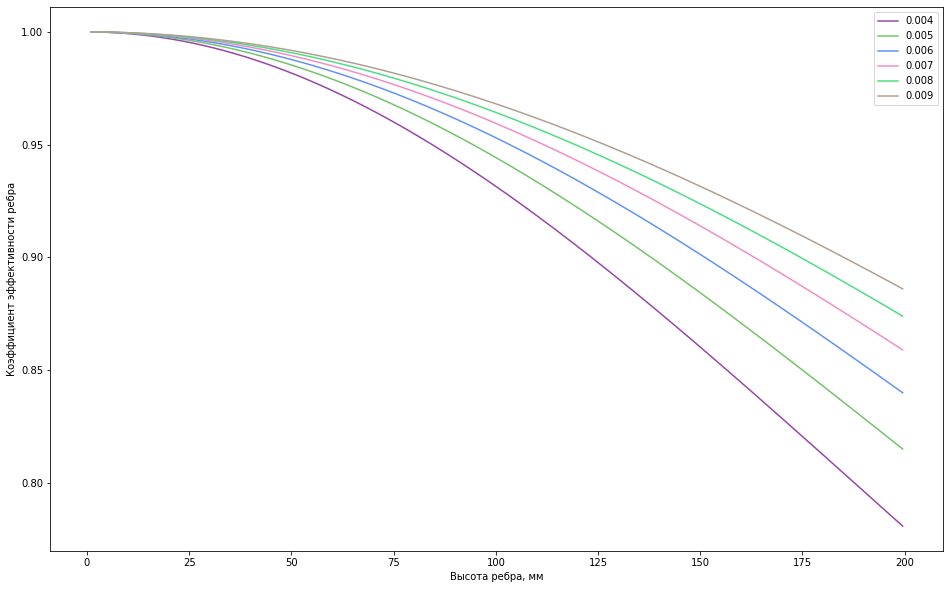

In [29]:
plt.figure(figsize=(16, 10))
for h in etas.columns:
    plt.plot(l_x, etas[h], label=h, color=np.random.rand(3))
    
plt.xlabel('Высота ребра, мм')
plt.ylabel('Коэффициент эффективности ребра')
plt.legend(loc="upper right", bbox_to_anchor=(1, 1))

plt.savefig('etas')

Как видим при небольших значениях высоты ребра коэффициент эффективности ребра не сильно зависит от толщины ребра.

### Итерационый алгоритм по параметрам: $T_{ст}, \delta, h$

$Gr=\frac{g h^3 \beta \Delta T}{\nu^2}$ [Гебхарт Б. "Свободноконвективные течения, тепло- и массообмен", 1991] $\Rightarrow$
$Nu=0.695 Gr^{0.25}$ [Михеев М.А., Михеева И.М., "Основы теплопередачи", 1977] $\Rightarrow$ $\alpha=\frac{Nu \lambda}{L}$ $\Rightarrow$ $m=\sqrt{\frac{2\alpha}{\lambda \delta}}$ $\Rightarrow$ $\eta_р$ $\Rightarrow$ $A_0$ $\Rightarrow$ $\Delta T=T_6-T_{ср}$ (перегрев по отношению к окружающей среде) $\Rightarrow$ $A$

In [30]:
import numpy as np

In [31]:
ys = np.linspace(0.008, 0.012, 1000)
dlts = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
L = 0.2
mu = 26.63e-6
beta = 3.665e-3
ls_air = [(340, 29.2), (350, 30.0), (360, 30.8), (370, 31.5),
            (380, 32.3), (390, 33.0), (400, 33.8), (420, 35.2)]

In [35]:
T_st = 95
variants = []
while (len(variants) < 1) and (T_st > 41):
    T_st -= 0.01
    # Определим коэф. теплопроводности воздуха при текущей температуре
    for i in range(len(ls_air) - 1):
        t1 = ls_air[i][0]
        t2 = ls_air[i + 1][0]
        if (T_st + 273.15 >= t1) and (T_st + 273.15 <= t2):
            lamda_air = (ls_air[i][1] + (ls_air[i + 1][1] - ls_air[i][1]) *\
                         (T_st + 273.15 - t1) / (t2 - t1)) / 1000
    
    for dlt in dlts:
        for h in range(50, 100):
            # Подберем количество ребер с учетом межреберного расстояния не меньше 8 мм
            y = 0
            for i in ys:
                if abs(Z / (i + dlt) - Z // (i + dlt)) < 5e-4:
                    y = i
            
            if y == 0:
                continue
            
            N = Z // (y + dlt)             ## кол-во ребер
            h = h / 1000
            A_r = N * L * (dlt + 2 * h)    ## площадь ребер
            A_0 = y * L * N + A_r          ## площадь всей ребристой пов-ти
            Gr = (9.8 * (h ** 3) * beta * (T_st - 40)) / (mu ** 2)
            Nu = 0.695 * (Gr ** 0.25)
            alpha = Nu * lamda_air / L
            m = sqrt(2 * alpha / (210 * i))
            eta = th(m * h) / (m * h)
            A = A_r * (1 - eta) + 15 / (alpha * (T_st - T_sr))
            eta_0 = 1 - (1 - eta) * A_r / A
            Q = alpha * (T_st - T_sr) * F * eta_0
            
            if abs(A - A_0) < 1e-3:
                variants.append((Q, T_st, alpha, h, dlt, y, N))

In [36]:
par = variants[0]
T_st = par[1]
alpha = par[2]
h = par[3]
delta = par[4]
y = par[5]
N = par[6]
print('Полученные параметры')
print(f'T_st = {T_st}')
print(f'alpha = {alpha}')
print(f'h = {h}')
print(f'delta = {delta}')
print(f'y = {y}')
print(f'N = {N}')

Полученные параметры
T_st = 89.50000000000031
alpha = 2.547601822679703
h = 0.05
delta = 0.008
y = 0.012
N = 5.0
